# 2025 CITS4012 Project 2

## 1. Preprocessing

### 1.1. Import Libraries
Libraries are imported for the entire project.

*Note: Just add to this list as needed*

In [36]:
%pip install gensim
import gensim.downloader as api

# from pydrive2.auth import GoogleAuth
# from pydrive2.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import itertools
import sys
import time
import torch
import spacy
import re
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(42)
random.seed(42)

Note: you may need to restart the kernel to use updated packages.


### 1.2. Retrieve Data
First, we need to retrieve the train/val/test datafiles from the Google Drive.

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
train_fileid = "1YEOo5vd8DXXUCf1FXCR1D3PxWR9XxQKv"
val_fileid = "15FEgtzzTVDMQcNVMgwIwqoAJeF9vmtrX"
test_fileid = "179nwaOvdkZ3ogsBaTSJvpZEIjq20uiG-"

train_file = drive.CreateFile({'id': train_fileid})
val_file = drive.CreateFile({'id': val_fileid})
test_file = drive.CreateFile({'id': test_fileid})

train_file.GetContentFile('train.json')
val_file.GetContentFile('val.json')
test_file.GetContentFile('test.json')

NameError: name 'drive' is not defined

### 1.3. Read in the Data
We now read in each dataset, splitting the input data and target data. The data shapes and a sample of the training data are shown below.

In [50]:
train = pd.read_json('train.json')
X_train = train[['premise', 'hypothesis']]
y_train = train['label']

val = pd.read_json('val.json')
X_val = val[['premise', 'hypothesis']]
y_val = val['label']

test = pd.read_json('test.json')
X_test = test[['premise', 'hypothesis']]
y_test = test['label']

print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
display(train)

Train shape: (23088, 2)
Val shape: (1304, 2)
Test shape: (2126, 2)


,premise,hypothesis,label
0,Pluto rotates once on its axis every 6.39 Eart...,Earth rotates on its axis once times in one day.,neutral
1,---Glenn =====================================...,Earth rotates on its axis once times in one day.,entails
2,geysers - periodic gush of hot water at the su...,The surface of the sun is much hotter than alm...,neutral
3,Facts: Liquid water droplets can be changed in...,Evaporation is responsible for changing liquid...,entails
4,"By comparison, the earth rotates on its axis o...",Earth rotates on its axis once times in one day.,entails
...,...,...,...
23083,"which is not only the motion of our bodies, bu...",Work is done only if a force is exerted in the...,neutral
23084,"The Red Star, that celestial curse whose eccen...",Red-shift refers to a shift toward red in the ...,neutral
23085,The lines in the spectrum of a luminous body s...,Red-shift refers to a shift toward red in the ...,entails
23086,The radial velocity of a star away from or tow...,Red-shift refers to a shift toward red in the ...,entails


### 1.4. Data preprocessing
As seen above, the data contains characters that requires cleaning before passing it to the model.

The preprocessing pipeline is as follows:
- Sentences are tokenised using SpaCy.
- A vocabulary list is constructed, including a padding and out-of-vocabulary tag.
- A GloVe Embedding model is loaded, pretrained on twitter.
- Tokenised sentences are converted to an indexed list of words, padded to the maximum size of the premise and hypothesis, respectively.

The labels are also converted to 0 or 1 (0 = neutral, 1 = entails).

#### 1.4.1. SpaCy Tokenisation
We tokenise the premises and hypotheses for the training set - removing all non alphanumeric characters and converting words to lower case.

In [51]:
spacy.cli.download('en_core_web_sm')
tokeniser = spacy.load('en_core_web_sm')
premise_list = X_train['premise'].tolist()
hypothesis_list = X_train['hypothesis'].tolist()

prem_tokens_list = list(tokeniser.pipe(premise_list, batch_size=64))
X_train.loc[:, "premise"] = [[token.text.lower() for token in tokens if re.match(r'^\w+$', token.text)] for tokens in prem_tokens_list]

hyp_tokens_list = list(tokeniser.pipe(hypothesis_list, batch_size=64))
X_train.loc[:, "hypothesis"] = [[token.text.lower() for token in tokens if re.match(r'^\w+$', token.text)] for tokens in hyp_tokens_list]

display(X_train)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


,premise,hypothesis
0,"[pluto, rotates, once, on, its, axis, every, e...","[earth, rotates, on, its, axis, once, times, i..."
1,"[once, per, day, the, earth, rotates, about, i...","[earth, rotates, on, its, axis, once, times, i..."
2,"[geysers, periodic, gush, of, hot, water, at, ...","[the, surface, of, the, sun, is, much, hotter,..."
3,"[facts, liquid, water, droplets, can, be, chan...","[evaporation, is, responsible, for, changing, ..."
4,"[by, comparison, the, earth, rotates, on, its,...","[earth, rotates, on, its, axis, once, times, i..."
...,...,...
23083,"[which, is, not, only, the, motion, of, our, b...","[work, is, done, only, if, a, force, is, exert..."
23084,"[the, red, star, that, celestial, curse, whose...","[red, shift, refers, to, a, shift, toward, red..."
23085,"[the, lines, in, the, spectrum, of, a, luminou...","[red, shift, refers, to, a, shift, toward, red..."
23086,"[the, radial, velocity, of, a, star, away, fro...","[red, shift, refers, to, a, shift, toward, red..."


#### 1.4.2. Vocabulary Construction

In [52]:
vocab_set = set([])
for tokens in X_train['premise']:
    for token in tokens:
        vocab_set.add(token)
for tokens in X_train['hypothesis']:
    for token in tokens:
        vocab_set.add(token)

# Convert the set to a list
vocab = ['[PAD]', '[OOV]']
vocab.extend(list(vocab_set))

wordindexes = {word: i for i, word in enumerate(vocab)}

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 20127


#### 1.4.3 Embedding Table Creation
We load the GloVe embeddings, and then for each word in the training set vocabulary, we add the embedding to our lookup table. If a word in the vocabulary does not exist in the GloVe embeddings, it is embedded as zeros.

In [53]:
glove_embeddings = api.load("glove-twitter-100")

emb_dim = glove_embeddings.vector_size
emb_table = []
for i, word in enumerate(vocab):
    if word in glove_embeddings:
        emb_table.append(glove_embeddings[word])
    else:
        emb_table.append(np.zeros(emb_dim))

emb_table = np.array(emb_table)
emb_table.shape

(20127, 100)

Later, we can now create an Embedding object that can be used to lookup the embeddings for any given word. This saves us from having to load the entire vocabulary embeddings at once during training.

### 1.5. Data visualisation
We will visualise the data to observe any patterns that we should be aware of before preprocessing and training.

First, lets observe the class balance for the train/val/test sets.

In [56]:
print(
    "Training set distribution:\n"
    f"Neutral = {round(y_train[y_train == 'neutral'].shape[0] / y_train.shape[0],2)}\n"
    f"Entails = {round(y_train[y_train == 'entails'].shape[0] / y_train.shape[0],2)}\n"
    "Validation set distribution:\n"
    f"Neutral = {round(y_val[y_val == 'neutral'].shape[0] / y_val.shape[0],2)}\n"
    f"Entails = {round(y_val[y_val == 'entails'].shape[0] / y_val.shape[0],2)}\n"
    "Testing set distribution:\n"
    f"Neutral = {round(y_test[y_test == 'neutral'].shape[0] / y_test.shape[0],2)}\n"
    f"Entails = {round(y_test[y_test == 'entails'].shape[0] / y_test.shape[0],2)}\n"
)

Training set distribution:
Neutral = 0.63
Entails = 0.37
Validation set distribution:
Neutral = 0.5
Entails = 0.5
Testing set distribution:
Neutral = 0.6
Entails = 0.4



The training set is strongly skewed towards neutral samples - this will have an impact on training.

Now, we will observe the distribution of the token lengths of the premises and hypotheses of the train and validation sets.

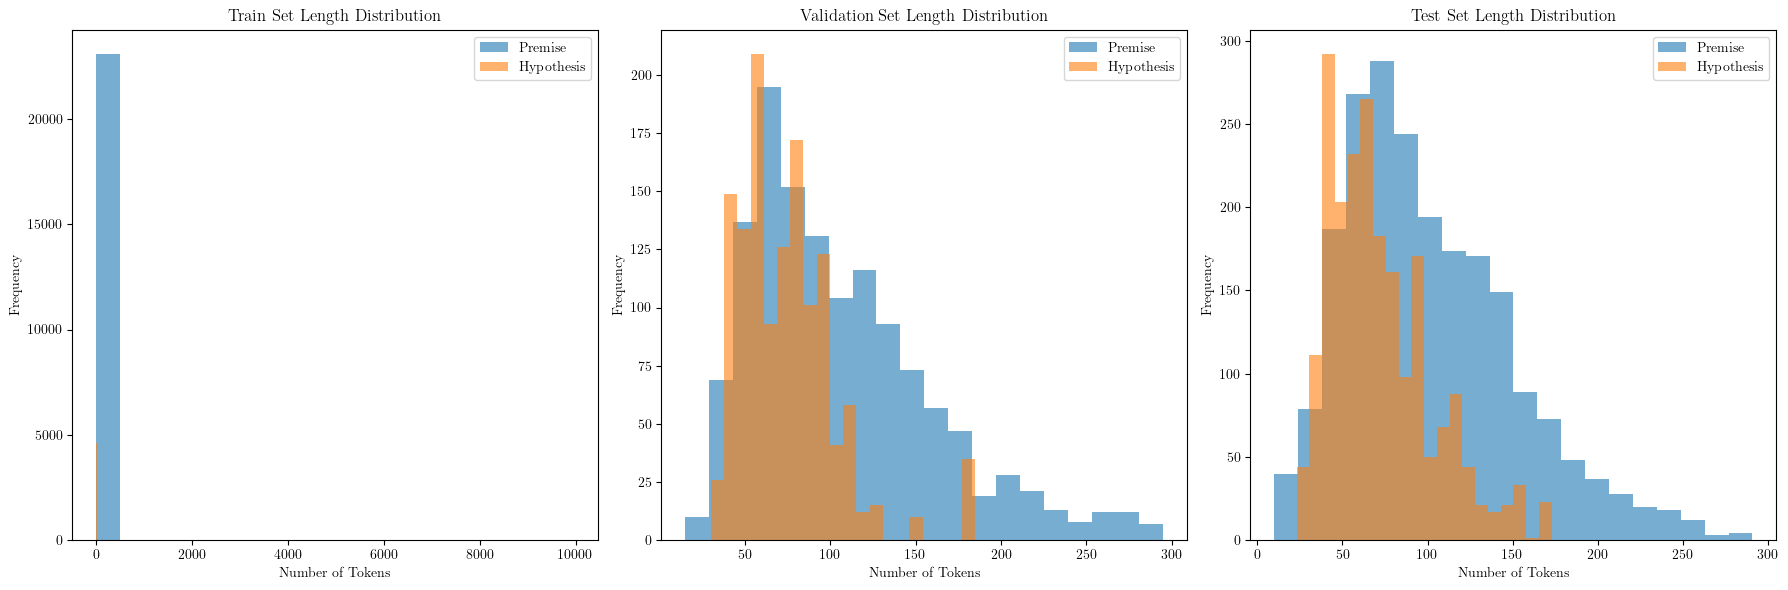

In [55]:
train_prem_lengths = [len(premise) for premise in X_train['premise']]
train_hyp_lengths = [len(hypothesis) for hypothesis in X_train['hypothesis']]

val_prem_lengths = [len(premise) for premise in X_val['premise']]
val_hyp_lengths = [len(hypothesis) for hypothesis in X_val['hypothesis']]

test_prem_lengths = [len(premise) for premise in X_test['premise']]
test_hyp_lengths = [len(hypothesis) for hypothesis in X_test['hypothesis']]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Train set
axs[0].hist(train_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[0].hist(train_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[0].set_title("Train Set Length Distribution")
axs[0].set_xlabel("Number of Tokens")
axs[0].set_ylabel("Frequency")
axs[0].legend()

# Validation set
axs[1].hist(val_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[1].hist(val_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[1].set_title("Validation Set Length Distribution")
axs[1].set_xlabel("Number of Tokens")
axs[1].set_ylabel("Frequency")
axs[1].legend()

axs[2].hist(test_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[2].hist(test_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[2].set_title("Test Set Length Distribution")
axs[2].set_xlabel("Number of Tokens")
axs[2].set_ylabel("Frequency")
axs[2].legend()

plt.tight_layout()
plt.show()

This indicates there are some outliers in the train set. To remove outliers (both small and large outliers), we removed the smallest and largest 2.5% of premises from the training set.

In [57]:
lower_prem, upper_prem = np.percentile(train_prem_lengths, [2.5, 97.5])
keep_indices = [i for i, pl in enumerate(train_prem_lengths) if lower_prem <= pl <= upper_prem]
X_train = X_train.iloc[keep_indices].reset_index(drop=True)
y_train = y_train.iloc[keep_indices].reset_index(drop=True)

Removing these outliers from the training set, we get a nicer looking plot:

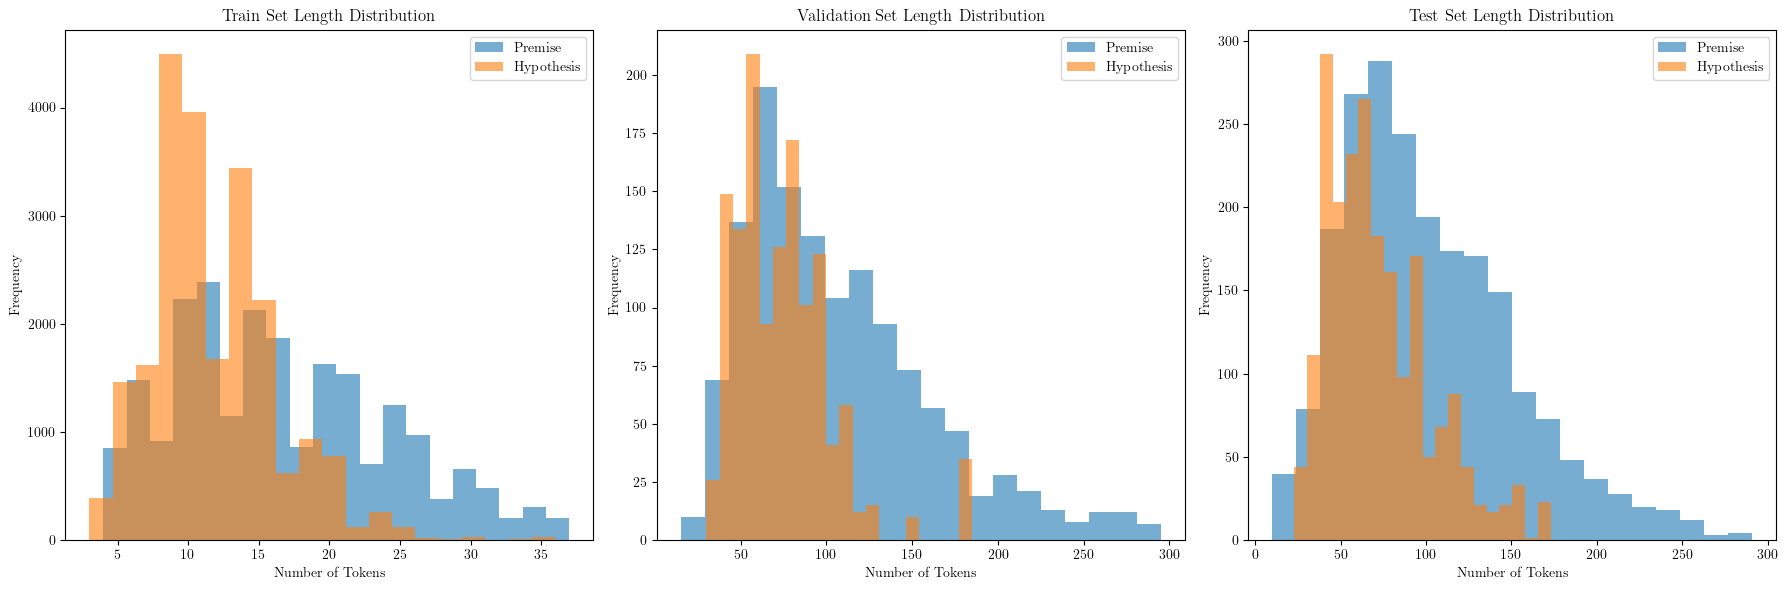

In [58]:
train_prem_lengths = [len(premise) for premise in X_train['premise']]
train_hyp_lengths = [len(hypothesis) for hypothesis in X_train['hypothesis']]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Train set
axs[0].hist(train_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[0].hist(train_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[0].set_title("Train Set Length Distribution")
axs[0].set_xlabel("Number of Tokens")
axs[0].set_ylabel("Frequency")
axs[0].legend()

# Validation set
axs[1].hist(val_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[1].hist(val_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[1].set_title("Validation Set Length Distribution")
axs[1].set_xlabel("Number of Tokens")
axs[1].set_ylabel("Frequency")
axs[1].legend()

axs[2].hist(test_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[2].hist(test_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[2].set_title("Test Set Length Distribution")
axs[2].set_xlabel("Number of Tokens")
axs[2].set_ylabel("Frequency")
axs[2].legend()

plt.tight_layout()
plt.show()

### 1.6. Dataset Formation
Now we create the training dataset. The tokenised premise and hypothesis sentences are encoded to be the index that corresponds to the word embedding in the embeddings table. Each sentence is then padded to be the same length as the longest respective premise or hypothesis.

In [59]:
def encode_sentences(sentences):
    encoded_sentences = []
    for sentence in sentences:
        encoded_sentences.append([wordindexes[word] if word in wordindexes else wordindexes['[OOV]'] for word in sentence])
    return encoded_sentences

def pad_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_length:
            padded_seq = seq + [wordindexes['[PAD]']] * (max_length - len(seq))
        else:
            padded_seq = seq[:max_length]
        padded_sequences.append(padded_seq)
    return padded_sequences

max_prem = max(len(sentence) for sentence in X_train['premise'])
max_hyp = max(len(sentence) for sentence in X_train['hypothesis'])
encoded_prem_train = pad_sequences(encode_sentences(X_train['premise']), max_prem)
encoded_hyp_train = pad_sequences(encode_sentences(X_train['hypothesis']), max_hyp)

encoded_prem_val = pad_sequences(encode_sentences(X_val['premise']), max_prem)
encoded_hyp_val = pad_sequences(encode_sentences(X_val['hypothesis']), max_hyp)

The labels are now converted to 0 for neutral, and 1 for entails.

In [60]:
y_train = y_train.map({'neutral': 0, 'entails': 1})
y_val = y_val.map({'neutral': 0, 'entails': 1})
y_test = y_test.map({'neutral': 0, 'entails': 1})

Now we can create the dataset and data loaders for the train and validation set. To reduce the impact of the class imbalance in the train set, the number of neutral samples is reduced to the number of entails samples.

In [61]:
batch_size = 64

train_data = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_train), torch.tensor(encoded_hyp_train), torch.tensor(y_train.values))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

val_data = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_val), torch.tensor(encoded_hyp_val), torch.tensor(y_val.values))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

In [62]:
class_counts = torch.bincount(torch.tensor(y_train.values))
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum() * len(class_weights)

print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: tensor([13914,  8284])
Class weights: tensor([0.7464, 1.2536])


### 1.7 Test Dataset
Finally, we create the test dataset in a similar way the training and validation sets are created.

In [63]:
max_prem = max(len(sentence) for sentence in X_test['premise'])
max_hyp = max(len(sentence) for sentence in X_test['hypothesis'])
encoded_prem_test = pad_sequences(encode_sentences(X_test['premise']), max_prem)
encoded_hyp_test = pad_sequences(encode_sentences(X_test['hypothesis']), max_hyp)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_test), torch.tensor(encoded_hyp_test), torch.tensor(y_test.values))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

## 2. GRU Model
To test the model, I have created a sample Bidirectional GRU model.

### 2.1. Training the Model
This first model is a Bidirectional GRU

In [76]:
class BiGRU(torch.nn.Module):
    def __init__(self, embedding_dim, individual_dim=64, combined_dim=128, linear_dim=64, num_layers=4, dropout=0.4):
        super(BiGRU, self).__init__()
        self.embeddings = torch.nn.Embedding(len(vocab), embedding_dim, padding_idx=wordindexes['[PAD]'])
        self.embeddings.weight.data.copy_(torch.from_numpy(emb_table))
        self.embeddings.weight.requires_grad = False

        self.norm = torch.nn.LayerNorm(embedding_dim)
        self.merged_norm = torch.nn.LayerNorm(combined_dim * 2)

        self.prem_gru = torch.nn.GRU(embedding_dim, individual_dim, num_layers, batch_first=True, bidirectional=True)
        self.hyp_gru = torch.nn.GRU(embedding_dim, individual_dim, num_layers, batch_first=True, bidirectional=True)

        self.combined_gru = torch.nn.GRU(individual_dim * 2, combined_dim, num_layers, batch_first=True, bidirectional=True)
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Dropout(dropout),
            torch.nn.Linear(combined_dim * 2, linear_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(linear_dim, 2),
        )

    def forward(self, prem, hyp):
        prem = self.embeddings(prem)
        hyp = self.embeddings(hyp)

        prem = self.norm(prem) 
        hyp = self.norm(hyp)

        prem_out, _ = self.prem_gru(prem)
        hyp_out, _ = self.hyp_gru(hyp)

        merged_out = torch.cat((prem_out, hyp_out), dim=1)
        merged_out, _ = self.combined_gru(merged_out)
        merged_out = torch.mean(merged_out, dim=1)
        merged_out = self.merged_norm(merged_out)

        logits = self.mlp(merged_out)
        return logits

Training function:

In [69]:
def train_model(model, optimiser, epochs, criterion, train_loader, val_loader, device):

    for epoch in range(epochs):
        model.train()

        train_loss = 0
        start_time = time.time()

        for i, batch in enumerate(train_loader):
            if i % 100 == 0:
                sys.stdout.write(f"\rEpoch: ({(epoch + 1):02} / {epochs:02}) | Batch: ({i} / {len(train_loader)}) | Loss: {train_loss / (i+1)}")
                sys.stdout.flush()

            premises = batch[0].to(device)
            hypotheses = batch[1].to(device)
            labels = batch[2].to(device).long()

            optimiser.zero_grad()
            outputs = model(premises, hypotheses)

            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimiser.step()


        model.eval()
        with torch.no_grad():
            val_loss = 0
            correct = 0

            for batch in val_loader:
                premises = batch[0].to(device)
                hypotheses = batch[1].to(device)
                labels = batch[2].to(device).long()
                outputs = model(premises, hypotheses)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()

            val_loss = val_loss / len(val_loader)
            val_acc = correct / len(val_loader.dataset)

        epoch_time = (time.time() - start_time)
        epoch_min = int(epoch_time // 60)
        epoch_sec = int(epoch_time % 60)
        train_loss = train_loss / len(train_loader)
        sys.stdout.write(f"\rEpoch: ({(epoch + 1):02} / {epochs:02}) | Time: {epoch_min:02d}:{epoch_sec:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.2f}\n")
    
    # Return final validation loss
    return val_loss

Now we can perform hyperparameter optimisation to find the parameters that achieve the highest performance:

In [77]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_weights = class_weights.to(device)
ind_dims_options = [64, 128]
comb_dims_options = [64, 128]
linear_dims_options = [64, 128, 256]
num_layers_options = [3, 4, 5]
dropout_options = [0.4]
epochs = 5

best_model = None
best_hyperparams = None
best_val_loss = 100 # arbitrary large number

all_hyperparams = list(itertools.product(ind_dims_options, comb_dims_options, linear_dims_options, num_layers_options, dropout_options))

for i, hyperparams in enumerate(all_hyperparams):
    print(f"Testing ({i}/{len(all_hyperparams)}): {hyperparams}")
    model = BiGRU(emb_dim, hyperparams[0], hyperparams[1], hyperparams[2], hyperparams[3], hyperparams[4])
    model.to(device)
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    val_loss = train_model(model, optimiser, epochs, criterion, train_loader, val_loader, device)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparams = hyperparams
        best_model = model
        print(f"Best Hyperparameters: [{hyperparams}] | Loss: {best_val_loss}")

print(f"Search complete. Best Hyperparameters: {best_hyperparams}.")

Testing (0/36): (64, 64, 64, 3, 0.4)
Epoch: (01 / 05) | Time: 00:03 | Train Loss: 0.7061 | Val Loss: 0.6740 | Val Accuracy: 0.51
Epoch: (02 / 05) | Time: 00:02 | Train Loss: 0.6961 | Val Loss: 0.6744 | Val Accuracy: 0.51
Epoch: (03 / 05) | Time: 00:02 | Train Loss: 0.6915 | Val Loss: 0.6761 | Val Accuracy: 0.51
Epoch: (04 / 05) | Time: 00:02 | Train Loss: 0.6879 | Val Loss: 0.6747 | Val Accuracy: 0.51
Epoch: (05 / 05) | Time: 00:03 | Train Loss: 0.6844 | Val Loss: 0.6732 | Val Accuracy: 0.51
Best Hyperparameters: [(64, 64, 64, 3, 0.4)] | Loss: 0.6732269866125924
Testing (1/36): (64, 64, 64, 4, 0.4)
Epoch: (01 / 05) | Time: 00:03 | Train Loss: 0.7079 | Val Loss: 0.6946 | Val Accuracy: 0.48
Epoch: (02 / 05) | Time: 00:03 | Train Loss: 0.7003 | Val Loss: 0.6883 | Val Accuracy: 0.51
Epoch: (03 / 05) | Time: 00:03 | Train Loss: 0.6942 | Val Loss: 0.6868 | Val Accuracy: 0.51
Epoch: (04 / 05) | Time: 00:03 | Train Loss: 0.6892 | Val Loss: 0.6832 | Val Accuracy: 0.51
Epoch: (05 / 05) | Time: 0

Retrain the best model hyperparameters:

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_weights = class_weights.to(device)
best_hyperparams = [128, 128, 512, 4, 0.4] # As above
model = BiGRU(emb_dim, individual_dim=best_hyperparams[0], combined_dim=best_hyperparams[1], linear_dim=best_hyperparams[2], num_layers=best_hyperparams[3], dropout=best_hyperparams[4])
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
val_loss = train_model(model, optimiser, 5, criterion, train_loader, val_loader, device)

Epoch: (01 / 05) | Time: 00:03 | Train Loss: 0.7072 | Val Loss: 0.6685 | Val Accuracy: 0.51
Epoch: (02 / 05) | Time: 00:03 | Train Loss: 0.6931 | Val Loss: 0.6649 | Val Accuracy: 0.51
Epoch: (03 / 05) | Time: 00:02 | Train Loss: 0.6782 | Val Loss: 0.6637 | Val Accuracy: 0.51
Epoch: (04 / 05) | Time: 00:02 | Train Loss: 0.6669 | Val Loss: 0.6644 | Val Accuracy: 0.51
Epoch: (05 / 05) | Time: 00:02 | Train Loss: 0.6580 | Val Loss: 0.6677 | Val Accuracy: 0.51


### 2.2. Testing Model on Test Dataset

              precision    recall  f1-score   support

         0.0       0.64      0.48      0.55      1284
         1.0       0.42      0.58      0.49       842

    accuracy                           0.52      2126
   macro avg       0.53      0.53      0.52      2126
weighted avg       0.55      0.52      0.53      2126



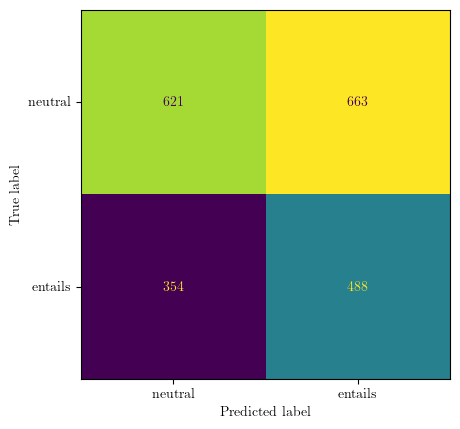

In [78]:
model = best_model
model.eval()

all_labels = []
all_predictions = []
with torch.no_grad():
    for batch in test_loader:
        premises = batch[0].to(device)
        hypotheses = batch[1].to(device)
        labels = batch[2].to(device).float()
        outputs = model(premises, hypotheses)
        preds = torch.argmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy().flatten())
        all_predictions.extend(preds.cpu().numpy().flatten())

print(classification_report(all_labels, all_predictions))

cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neutral", "entails"])
disp.plot(colorbar=False)

plt.show()